# Author: S.R.E.A Bagcik
### E-mail: s.r.e.a.bagcik@lumc.nl / seanbagcik@hotmail.com

### Contents

* [Packages](#chapter1)
* [Data Wrangling](#chapter2)
* [Silhouette Analysis - Euclidean Distance](#chapter3)
* [Silhouette Analysis - Gower's Distance](#chapter4)
* [The Gap Statistic - Euclidean Distance](#chapter5)
    * [Plotting the Gap Statistic - KMedoids](#section_5_1)
* [The Gap Statistic - Gower's Distance](#chapter6)    
* [Stability Function: Rand & adjusted Rand Index](#chapter7)
* [Scenario 1](#chapter8)
* [Scenario 1: Prognostic Value & Stability Bootstrap "DRY-er"](#chapter9)
* [Scenario 1: SHAP Analysis](#chapter10)
* [Grid Search Gaussian Mixture](#chapter11)
* [Scenario 2](#chapter12)
* [Scenario 2: Prognostic Value & Stability Bootstrap](#chapter13)
* [Scenario 2: SHAP Analysis](#chapter14) 
* [Agreement: Pair-Confusion Matrix](#chapter15)
* [Agreement: Contingency Table](#chapter16)

## Packages <a class="anchor" id="chapter1"></a>

In [2]:
import os
from collections import Counter
from itertools import combinations
from typing import Callable, Union
import warnings

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sn
import shap
import statsmodels.api as sm
from pprint import pprint

from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

import gower

from scipy.cluster.hierarchy import linkage
from scipy.stats import sem
from sklearn import metrics, mixture
from sklearn.cluster import (
    AgglomerativeClustering,
    AffinityPropagation,
    Birch,
    DBSCAN,
    KMeans,
    MeanShift,
    OPTICS,
    SpectralClustering
)
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    adjusted_mutual_info_score,
    log_loss,
    mutual_info_score,
    normalized_mutual_info_score,
    pairwise_distances,
    roc_auc_score,
    silhouette_samples,
    silhouette_score,
)
from sklearn.metrics.cluster import contingency_matrix, pair_confusion_matrix
from sklearn.metrics.cluster._expected_mutual_info_fast import expected_mutual_information
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid, kneighbors_graph
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.utils import check_random_state, resample

warnings.filterwarnings("ignore")

In [23]:
DATA_DIR = '/Users/seanvanbork/Desktop/multiverse_cluster_analysis'
os.chdir(DATA_DIR)

!jupyter nbconvert --to html --TagRemovePreprocessor.remove_cell_tags={'no'} bagcik_s_multiverse_analysis_clustering.ipynb

[NbConvertApp] Converting notebook bagcik_s_multiverse_analysis_clustering.ipynb to html
[NbConvertApp] Writing 915156 bytes to bagcik_s_multiverse_analysis_clustering.html


## Data Directory

In [3]:
DATA_DIR = '/Users/seanvanbork/Desktop/multiverse_cluster_analysis/Data'
os.chdir(DATA_DIR)

## Data

In [4]:
cluster_vars = pd.read_csv(os.path.join(DATA_DIR, 'OPAL/OPAL_cluster_vars.csv'))

gower_matrix = pd.read_csv(os.path.join(DATA_DIR, 'OPAL/OPAL_gower_matrix.csv'))

y = pd.read_csv(os.path.join(DATA_DIR, 'OPAL/OPAL_GOSE6monthEndpointDerived.csv'))

## Data Wrangling <a class="anchor" id="chapter2"></a>

In this code block, we dichotomize the 6-month extended Glasgow Outcome Scale (GOSE). Subsequently, we encode the ordinal categorical feature pupil score. We create dummy variables for the feature injury cause, which is non-ordinal categorical. Last, we scale our features to avoid the scale influencing the Euclidean distance in scenario 2. 

In [5]:
# Dichotomize
y_dich = (y >= 5).astype(int)

# Encode "PupilsBaselineDerived" (Ordinal categorical)
encoder = LabelEncoder()
cluster_vars_encoded = cluster_vars.copy()
cluster_vars_encoded['InjuryHx.PupilsBaselineDerived'] = encoder.fit_transform(
    cluster_vars_encoded['InjuryHx.PupilsBaselineDerived'])

# Features for reference distribution in Gap Method
cluster_vars_gap = cluster_vars_encoded.copy()
cluster_vars_gap['InjuryHx.InjCause'] = encoder.fit_transform(
    cluster_vars_encoded['InjuryHx.InjCause'])

# One-hot-encoding "InjuryHx.InjCause" (Categorical, but equal weights)
dummy_columns = pd.get_dummies(cluster_vars_encoded['InjuryHx.InjCause'])
cluster_vars_encoded = pd.concat(
    [cluster_vars_encoded.drop('InjuryHx.InjCause', axis=1), dummy_columns],
    axis=1)

# Scaling the data
columns_to_scale = [
    'Subject.Age', 'InjuryHx.GCSMotorBaselineDerived',
    'InjuryHx.GCSScoreBaselineDerived', 'dim1', 'dim2', 'dim3', 'dim4'
]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_vars_encoded[columns_to_scale])
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
non_scaled_columns = [
    col for col in cluster_vars_encoded.columns if col not in columns_to_scale
]

cluster_vars_encoded_scaled = pd.concat(
    [cluster_vars_encoded[non_scaled_columns], scaled_df], axis=1)

print("Features used in the cluster analysis: \n")
for i, column in enumerate(cluster_vars.columns, 1):
    print(f"{i}. {column}")

Features used in the cluster analysis: 

1. Subject.Age
2. InjuryHx.GCSMotorBaselineDerived
3. InjuryHx.GCSScoreBaselineDerived
4. InjuryHx.PupilsBaselineDerived
5. InjuryHx.EDComplEventHypoxia
6. InjuryHx.EDComplEventHypotension
7. InjuryHx.InjCause
8. InjuryHx.MajorExtracranialInjury
9. dim1
10. dim2
11. dim3
12. dim4


## Silhouette Analysis - Euclidean Distance <a class="anchor" id="chapter3"></a>

In this cell we present the function that performs a silhouette analysis with Euclidean, respectively Gower's distance to select the "optimal" number of clusters for the three clustering algorithms of Scenario 1.

In [6]:
def best_silhouette_euclidean(algorithm, data, range_n_clusters):

    max_silhouette_avg = -1
    best_n_clusters = -1
    silhouette_values = [
    ]  # List to store silhouette scores for each iteration

    # Iterate over range of cluster numbers
    for n_clusters in range_n_clusters:
        # Choose clustering algorithm
        if algorithm == KMedoids:
            clusterer = algorithm(n_clusters=n_clusters,
                                  method='alternate').fit(data)
        elif algorithm == AgglomerativeClustering:
            clusterer = algorithm(n_clusters=n_clusters,
                                  linkage='average').fit(data)
        elif algorithm == SpectralClustering:
            clusterer = algorithm(n_clusters=n_clusters,
                                  affinity='nearest_neighbors').fit(data)

        cluster_labels = clusterer.labels_

        # Calculate silhouette score only if there is more than one cluster
        if len(set(cluster_labels)) == 1:
            silhouette_avg = 0
        else:
            silhouette_avg = silhouette_score(data, cluster_labels)

        # Append the silhouette score
        silhouette_values.append(silhouette_avg)

        # Update the best silhouette score
        if silhouette_avg > max_silhouette_avg:
            max_silhouette_avg = silhouette_avg
            best_n_clusters = n_clusters

    return best_n_clusters, silhouette_values

## Silhouette Analysis - Gower's distance <a class="anchor" id="chapter4"></a>

In [7]:
def best_silhouette_gower(algorithm, distance, range_n_clusters):
    max_silhouette_avg = -1
    best_n_clusters = -1
    silhouette_values = [
    ]  # List to store silhouette scores for each iteration

    # Iterate over range of cluster numbers
    for n_clusters in range_n_clusters:
        # Choose clustering algorithm
        if algorithm == KMedoids:
            clusterer = algorithm(n_clusters=n_clusters,
                                  method='alternate',
                                  metric='precomputed').fit(distance)
        elif algorithm == AgglomerativeClustering:
            clusterer = algorithm(n_clusters=n_clusters,
                                  affinity='precomputed',
                                  linkage='average').fit(distance)
        elif algorithm == SpectralClustering:
            clusterer = algorithm(n_clusters=n_clusters,
                                  affinity='precomputed').fit(1 - distance)

        cluster_labels = clusterer.labels_

        # Calculate silhouette score only if there is more than one cluster
        if len(set(cluster_labels)) == 1:
            silhouette_avg = 0
        else:
            silhouette_avg = silhouette_score(distance,
                                              cluster_labels,
                                              metric='precomputed')

        # Append silhouette score
        silhouette_values.append(silhouette_avg)

        # Update the best silhouette score
        if silhouette_avg > max_silhouette_avg:
            max_silhouette_avg = silhouette_avg
            best_n_clusters = n_clusters

    return best_n_clusters, silhouette_values

## The Gap Statistic - Euclidean Distance <a class="anchor" id="chapter5"></a>

In this cell we present a function that implements the Gap method with Euclidean, respectively Gower's distance (Tibshirani, R., Walther, G., & Hastie, T. (2001)) to give us the "optimal" number of clusters. 

In [16]:
class GapStatistics:
    def __init__(self, return_params: bool = True):
        self.return_params = return_params

    def _calculate_Wks(self, algorithm, K: int, X: pd.DataFrame) -> list:
        dummy_columns = pd.get_dummies(X['InjuryHx.InjCause'])
        X = pd.concat([X.drop('InjuryHx.InjCause', axis=1), dummy_columns], axis=1)
        X.columns = X.columns.astype(str)
        Wks = []

        for k in np.arange(2, K + 1):
            if algorithm == KMedoids:
                clusterer = algorithm(n_clusters=k, method='alternate').fit(X)
                labels = clusterer.predict(X)
                centroids = clusterer.cluster_centers_
            elif algorithm == AgglomerativeClustering:
                labels = algorithm(n_clusters=k, linkage='average').fit_predict(X)
                tmp = NearestCentroid()
                tmp.fit(X, labels)
                centroids = tmp.centroids_
            elif algorithm == SpectralClustering:
                labels = algorithm(n_clusters=k, affinity='nearest_neighbors').fit_predict(X)
                tmp = NearestCentroid()
                tmp.fit(X, labels)
                centroids = tmp.centroids_

            Ds = []
            for i in range(k):
                cluster_array = np.array(X[labels == i])
                if len(cluster_array) > 0:  # Ensure there are elements in the cluster
                    d = pairwise_distances(cluster_array, centroids[i].reshape(1, -1), metric='euclidean')
                    Ds.append(np.sum(d))

            if Ds:  # Ensure Ds is not empty
                Wk = np.sum(Ds) / (2 * len(X))
                Wks.append(Wk)

        return Wks

    def _simulate_Wks(self, algorithm, X: pd.DataFrame, K: int, n_iterations: int) -> [list, list]:
        cat_columns = [3, 4, 5, 6, 7]
        cont_columns = [0, 1, 2, 8, 9, 10, 11]

        cat = X.iloc[:, cat_columns]
        cont = X.iloc[:, cont_columns]

        simulated_Wks = []

        for i in range(n_iterations):
            sampled_X = X.copy()
            for col in cat.columns:
                low = cat[col].min()
                high = max(cat[col].max(), 1)
                sampled_X[col] = np.random.randint(low=low, high=high, size=len(X))

            for col in cont.columns:
                low = cont[col].min()
                high = max(cont[col].max(), 1)
                sampled_X[col] = np.random.uniform(low=low, high=high, size=len(X))

            Wks_star = self._calculate_Wks(algorithm=algorithm, K=K, X=sampled_X)
            simulated_Wks.append(Wks_star)

        sim_Wks = np.array(simulated_Wks)
        return sim_Wks

    def fit_predict(self, algorithm, K: int, X: pd.DataFrame, n_iterations: int = 15):
        self.n_iterations = n_iterations
        Wks = self._calculate_Wks(algorithm=algorithm, K=K, X=X)
        sim_Wks = self._simulate_Wks(algorithm=algorithm, K=K, X=X, n_iterations=n_iterations)

        log_Wks = np.log(Wks)
        log_Wks_star = np.log(sim_Wks)

        sd_k = np.std(log_Wks_star, axis=0)
        sim_sks = np.sqrt(1 + (1 / n_iterations)) * sd_k

        gaps = np.mean(log_Wks_star - log_Wks, axis=0)

        optimum = 1
        max_gap = gaps[0]

        for i in range(0, len(gaps) - 1):
            if gaps[i] >= gaps[i + 1] - sim_sks[i + 1]:
                if gaps[i] > max_gap:
                    optimum = i
                    max_gap = gaps[i]

        self.optimum = optimum
        self.params = {
            'Wks': Wks,
            'sim_Wks': sim_Wks,
            'sim_sks': sim_sks,
            'gaps': gaps
        }

        if self.return_params:
            return optimum, self.params
        else:
            return optimum

    def plot(self, original_labels: list = None, colors: dict = None):
        def _clip_values(arr):
            for i in range(len(arr)):
                if arr[i] < 0:
                    arr[i] = 0
                elif arr[i] > 1:
                    arr[i] = 1
            return arr

        Wks = self.params['Wks']
        sim_Wks = self.params['sim_Wks']
        sim_sks = self.params['sim_sks']
        gaps = self.params['gaps']

        log_Wks = np.log(Wks)
        log_sim_Wks = np.log(np.mean(sim_Wks, axis=0))

        if colors is None:
            colors = {
                0: "red", 1: "green", 2: 'blue', 3: 'lightblue',
                4: 'yellow', 5: 'pink', 6: 'orange', 7: 'purple',
                8: 'magenta', 9: 'black'
            }

        plt.figure(figsize=(16, 10))

        log_Wks = log_Wks - np.max(log_Wks)
        log_sim_Wks = log_sim_Wks - np.max(log_sim_Wks, axis=0)
        Wks = Wks - np.max(Wks)

        plt.subplot(2, 2, 4)
        plt.plot(Wks, '-o', label="Wks from Data")
        plt.plot(log_Wks, '-o', label="Logged Wks from Data")
        plt.plot(log_sim_Wks, '-o', color="green", label=f"Logged Simulated Wks [{self.n_iterations}]")
        plt.title("Decrease of Within Cluster Distance")
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(gaps, '-o', color='r')

        yminx = ((gaps - sim_sks) - np.min(gaps)) / (np.max(gaps) - np.min(gaps))
        ymaxsx = ((gaps + sim_sks) - np.min(gaps)) / (np.max(gaps) - np.min(gaps))

        clipped_yminx = _clip_values(yminx)
        clipped_ymaxsx = _clip_values(ymaxsx)

        for i in range(len(gaps)):
            plt.axvline(
                x=i, ymin=clipped_yminx[i], ymax=clipped_ymaxsx[i], color='black'
            )

        plt.axvline(x=self.optimum, color='green')
        plt.title("Gap Statistics with optimum K at {}".format(self.optimum))

        plt.show()

GapStatEucl = GapStatistics(return_params=False)

## Plotting the Gap Statistic - KMedoids <a class="anchor" id="section_5_1"></a>

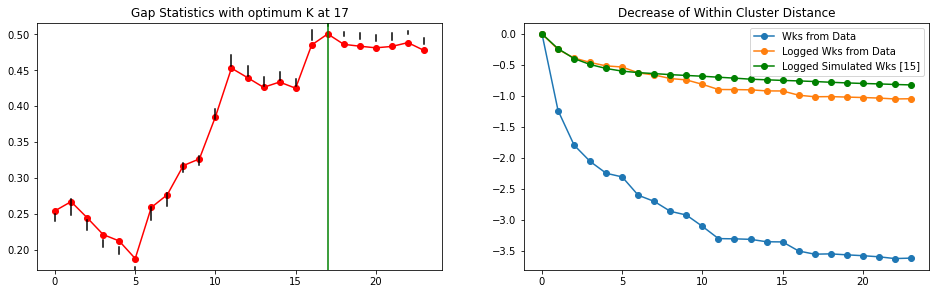

In [14]:
algorithms = {
    'KMedoids': KMedoids,
    'AgglomerativeClustering': AgglomerativeClustering,
    'SpectralClustering': SpectralClustering
}

results = {}

for algorithm_name, algorithm in algorithms.items():
    optimum, params = GapStatEucl.fit_predict(algorithm=algorithm, K=25, X=cluster_vars_gap)
    results[algorithm_name] = {'model': GapStatEucl, 'optimum': optimum, 'params': params}
    
results['KMedoids']['model'].plot()

## The Gap Statistic - Gower's Distance <a class="anchor" id="chapter6"></a>

In this cell we present a function that implements the Gap method with Gower's distance to give us the "optimal" number of clusters.

In [15]:
class GapStatisticsGower:

    def __init__(self, return_params: bool = True):
        self.return_params = return_params

    def _calculate_Wks(self, algorithm, K: int, X: pd.DataFrame) -> list:
        """
        Calculate Wk for clustering algorithm and number of clusters (K)
        
        Parameters:
        - algorithm: The clustering algorithm to be used
        - K: Number of clusters
        - X: Input data as a pandas DataFrame
        
        Returns:
        - list of Wks values
        """
        
        # Dummy encoding for categorical columns
        dummy_columns = pd.get_dummies(X['InjuryHx.InjCause'])
        X = pd.concat([X.drop('InjuryHx.InjCause', axis=1), dummy_columns], axis=1)
        X.columns = X.columns.astype(str)
        Wks = []

        for k in np.arange(2, K):
            if algorithm == KMedoids:
                clusterer = algorithm(n_clusters=k, method='alternate').fit(X)
                labels = clusterer.predict(X)
            elif algorithm == AgglomerativeClustering:
                labels = AgglomerativeClustering(n_clusters=k, linkage='average').fit_predict(X)
            elif algorithm == SpectralClustering:
                labels = SpectralClustering(n_clusters=k, affinity='nearest_neighbors').fit_predict(X)

            X['labels'] = labels

            Ds = []
            for label in np.unique(X['labels']):
                data = X[X['labels'] == label].drop(columns=['labels'])
                n_k = len(data)
                pooled = 1 / (2 * n_k)
                d = np.sum(gower.gower_matrix(data))
                Ds.append(d)

            Wk = np.sum([D * pooled for D in Ds])
            Wks.append(Wk)
            X.drop(columns=['labels'], inplace=True)

        return Wks

    def _simulate_Wks(self, algorithm, X: pd.DataFrame, K: int, n_iterations: int) -> [list, list]:
        """
        Simulate Wks values for multiple iterations by randomizing data.
        
        Parameters:
        - algorithm: clustering algorithm to be used
        - X: Input data as a pandas DataFrame
        - K: Number of clusters
        - n_iterations: Number of iterations for simulation
        
        Returns:
        - list of simulated Wks values
        """
        
        cat_columns = [3, 4, 5, 6, 7]
        cont_columns = [0, 1, 2, 8, 9, 10, 11]

        cat = X.iloc[:, cat_columns]
        cont = X.iloc[:, cont_columns]

        sampled_X = X.copy()

        # Randomly sample categorical and continuous columns
        for col in cat.columns:
            low = cat[col].min()
            high = max(cat[col].max(), 1)
            sampled_X[col] = np.random.randint(low=low, high=high, size=len(X))

        for col in cont.columns:
            low = cont[col].min()
            high = max(cont[col].max(), 1)
            sampled_X[col] = np.random.uniform(low=low, high=high, size=len(X))

        simulated_Wks = []

        for i in range(n_iterations):
            # Calculate Wks for each iteration
            Wks_star = self._calculate_Wks(algorithm=algorithm, K=K, X=sampled_X)
            simulated_Wks.append(Wks_star)

        sim_Wks = np.array(simulated_Wks)
        return sim_Wks

    def fit_predict(self, algorithm, K: int, X: pd.DataFrame, n_iterations: int = 15):
        """
        Fit the clustering algorithm, calculate Wks, and simulate Wks values
        
        Parameters:
        - algorithm: The clustering algorithm to be used
        - K: Number of clusters
        - X: Input data as a pandas DataFrame.
        - n_iterations: Number of iterations for simulation
        
        Returns:
        - the optimum number of clusters and additional information if return_params is True
        """
        self.n_iterations = n_iterations
        Wks = self._calculate_Wks(algorithm=algorithm, K=K, X=X)
        sim_Wks = self._simulate_Wks(algorithm=algorithm, K=K, X=X, n_iterations=n_iterations)

        log_Wks = np.log(Wks)
        log_Wks_star = np.log(sim_Wks)

        sd_k = np.std(log_Wks_star, axis=0)
        sim_sks = np.sqrt(1 + (1 / n_iterations)) * sd_k

        gaps = np.mean(log_Wks_star - log_Wks, axis=0)

        optimum = 1
        max_gap = gaps[0]

        # GAP - FORMULA (3)
        for i in range(0, len(gaps) - 1):
            if gaps[i] >= gaps[i + 1] - sim_sks[i + 1]:
                if gaps[i] > max_gap:
                    optimum = i
                    max_gap = gaps[i]

        self.params = {
            'Wks': Wks,
            'sim_Wks': sim_Wks,
            'sim_sks': sim_sks,
            'gaps': gaps
        }
        self.optimum = optimum

        if self.return_params:
            return optimum, self.params
        else:
            return optimum
        
GapStatGow = GapStatisticsGower(return_params=False)

## Stability Function: Rand & adjusted Rand Index <a class="anchor" id="chapter7"></a>

This function calculates the stability of a clustering method given a number of bootstraps $B=200$ quantified via the Rand and adjusted Rand index.

In [17]:
def stability_bootstrap(labels, n_bootstraps):

    rands = []
    arands = []

    for i in range(0, n_bootstraps - 1):
        for j in range(i + 1, n_bootstraps):

            pairconf = pair_confusion_matrix(labels.iloc[:, i], labels.iloc[:,j])

            a = pairconf[1, 1]  # pairs grouped together in both
            b = pairconf[1, 0]
            c = pairconf[0, 1]
            d = pairconf[0, 0]  # pairs not grouped together in both

            rand = (a + d) / (a + d + b + c)
            arand = 2 * (a * d - b * c) / ((a + b) * (d + b) + (a + c) * (d + c))

            rands.append(rand)
            arands.append(arand)

    scores = pd.DataFrame({'Rand': rands, 'Adjusted Rand': arands})

    return print(scores.mean())

## Scenario 1 <a class="anchor" id="chapter8"></a>

In this cell we prepare the clustering algorithms of Scenario 1. The hard-coded values imply the "optimal" number of clusters give one of the four cluster selection methods: Silhouette with Euclidean distance, Silhouette with Gower's distance, the Gap method with Euclidean distance and the Gap method with Gower's distance.

In [18]:
def prepare_algorithms():

    # Calculate the "optimal" number of clusters

    optimal_n = {}

    algorithms = {
        'KMedoids': KMedoids,
        'AgglomerativeClustering': AgglomerativeClustering,
        'SpectralClustering': SpectralClustering
    }

    for algorithm_name, algorithm in algorithms.items():
        optimal_n[algorithm_name] = {
            'n_eucl_sil':
            best_silhouette_euclidean(algorithm, cluster_vars_encoded,
                                      range(2, 25))[0],
            'n_eucl_gap':
            GapStatEucl.fit_predict(algorithm, 25, cluster_vars_gap),
            'n_gow_sil':
            best_silhouette_gower(algorithm, gower_matrix, range(2, 25))[0],
            'n_gow_gap':
            GapStatGow.fit_predict(algorithm, 25, cluster_vars_gap)
        }
        
    print("----- Optimal Clusters for Each Algorithm -----")
    for algorithm_name, metrics in optimal_n.items():
        print(f"Algorithm: {algorithm_name}")
        for metric_name, value in metrics.items():
            print(f"  {metric_name: <10}: {value}")
        print("-" * 45)
    print() # blank line

    km_gow_sil = KMedoids(n_clusters=optimal_n['KMedoids']['n_gow_sil'],
                          metric='precomputed',
                          method='pam')
    km_eucl_sil = KMedoids(n_clusters=optimal_n['KMedoids']['n_eucl_sil'],
                           method='pam')

    ac_gow_sil = AgglomerativeClustering(
        n_clusters=optimal_n['AgglomerativeClustering']['n_gow_sil'],
        affinity='precomputed',
        linkage='average')
    ac_eucl_sil = AgglomerativeClustering(
        n_clusters=optimal_n['AgglomerativeClustering']['n_eucl_sil'],
        linkage='average')

    sc_gow_sil = SpectralClustering(
        n_clusters=optimal_n['SpectralClustering']['n_gow_sil'],
        affinity='precomputed')
    sc_eucl_sil = SpectralClustering(
        n_clusters=optimal_n['SpectralClustering']['n_eucl_sil'],
        affinity='nearest_neighbors')

    km_gow_gap = KMedoids(n_clusters=optimal_n['KMedoids']['n_gow_gap'],
                          metric='precomputed',
                          method='pam')
    km_eucl_gap = KMedoids(n_clusters=optimal_n['KMedoids']['n_eucl_gap'],
                           method='pam')

    ac_gow_gap = AgglomerativeClustering(
        n_clusters=optimal_n['AgglomerativeClustering']['n_gow_gap'],
        affinity='precomputed',
        linkage='average')

    ac_eucl_gap = AgglomerativeClustering(
        n_clusters=optimal_n['AgglomerativeClustering']['n_eucl_gap'],
        linkage='average')

    sc_gow_gap = SpectralClustering(
        n_clusters=optimal_n['SpectralClustering']['n_gow_gap'],
        affinity='precomputed')
    sc_eucl_gap = SpectralClustering(
        n_clusters=optimal_n['SpectralClustering']['n_eucl_gap'],
        affinity='nearest_neighbors')

    return [('KM-Gow-Sil', km_gow_sil), ('KM-Eucl-Sil', km_eucl_sil),
            ('AC-Gow-Sil', ac_gow_sil), ('AC-Eucl-Sil', ac_eucl_sil),
            ('SC-Gow-Sil', sc_gow_sil), ('SC-Eucl-Sil', sc_eucl_sil),
            ('KM-Gow-Gap', km_gow_gap), ('KM-Eucl-Gap', km_eucl_gap),
            ('AC-Gow-Gap', ac_gow_gap), ('AC-Eucl-Gap', ac_eucl_gap),
            ('SC-Gow-Gap', sc_gow_gap), ('SC-Eucl-Gap', sc_eucl_gap)]

clustering_algorithms = prepare_algorithms()

def get_labels(X, X_distance, X_similarity):
    labels = {}

    for algorithm_name, algorithm in clustering_algorithms:
        try:
            if algorithm_name.startswith('SC') and algorithm_name.endswith(
                ('Gow-Sil', 'Gow-Gap')):
                algorithm.fit(X_similarity)
            elif algorithm_name.startswith(
                ('KM', 'AC')) and algorithm_name.endswith(
                    ('Gow-Sil', 'Gow-Gap')):
                algorithm.fit(X_distance)
            else:
                algorithm.fit(X)

            if hasattr(algorithm, 'labels_'):
                labels[algorithm_name] = algorithm.labels_.astype(int)
            else:
                raise AttributeError(
                    f"{algorithm_name} does not have a labels_ attribute.")

        except Exception as e:
            print(f"Error: {algorithm_name} could not be fitted. {e}")

    return labels

cluster_labels = get_labels(cluster_vars_encoded, gower_matrix,
                            1 - gower_matrix)

def print_label_counts(cluster_labels, X, X_distance):
    if not cluster_labels:
        print("Error: Input is empty.")
        return

    for algorithm_name, labels in cluster_labels.items():
        label_counts = Counter(labels)
        cluster_sizes = list(label_counts.values())

        print(f"Algorithm: {algorithm_name}")
        print(f"Number of unique labels: {len(label_counts)}")
        print(f"Smallest: {min(cluster_sizes)}")
        print(f"Largest: {max(cluster_sizes)}")
        print(f"Average: {np.mean(cluster_sizes)}")
        print(f"Median: {np.median(cluster_sizes)}")

        if len(label_counts) == 1:
            print("Silhouette score: Not applicable (only one cluster)\n")
            continue
        if algorithm_name.endswith('Gap'):
            print("Silhouette score: Not applicable (Gap Method)\n")
            continue
        if algorithm_name.endswith('Gow-Sil'):
            silhouette = silhouette_score(X_distance,
                                          labels,
                                          metric='precomputed')
            print(f"Silhouette score: {silhouette}\n")
        else:
            silhouette = silhouette_score(X, labels, metric='euclidean')
            print(f"Silhouette score: {silhouette}\n")

print_label_counts(cluster_labels, cluster_vars_encoded, gower_matrix)

----- Optimal Clusters for Each Algorithm -----
Algorithm: KMedoids
  n_eucl_sil: 2
  n_eucl_gap: 18
  n_gow_sil : 3
  n_gow_gap : 16
---------------------------------------------
Algorithm: AgglomerativeClustering
  n_eucl_sil: 2
  n_eucl_gap: 17
  n_gow_sil : 2
  n_gow_gap : 9
---------------------------------------------
Algorithm: SpectralClustering
  n_eucl_sil: 2
  n_eucl_gap: 17
  n_gow_sil : 2
  n_gow_gap : 13
---------------------------------------------

Algorithm: KM-Gow-Sil
Number of unique labels: 3
Smallest: 973
Largest: 1989
Average: 1503.0
Median: 1547.0
Silhouette score: 0.22179634303778145

Algorithm: KM-Eucl-Sil
Number of unique labels: 2
Smallest: 1986
Largest: 2523
Average: 2254.5
Median: 2254.5
Silhouette score: 0.5575120008521547

Algorithm: AC-Gow-Sil
Number of unique labels: 2
Smallest: 2
Largest: 4507
Average: 2254.5
Median: 2254.5
Silhouette score: 0.4498339110069868

Algorithm: AC-Eucl-Sil
Number of unique labels: 2
Smallest: 1277
Largest: 3232
Average: 2254

In [16]:
cluster_labels = pd.DataFrame(cluster_labels)
cluster_labels.to_csv('cluster_labels_S1.csv')

## Scenario 1: Prognostic Value & Stability Bootstrap

This cell calculates the prognostic value of the clusterings for Scenario 1. This involves a bootstrap procedure over the four selection methods for $n$, the "optimal" number of clusters: Silhouette-Euclidean; Silhouette-Gower's; Gap-Method-Euclidean and Gap-Method-Gower's. 

In [ ]:
# Read cluster labels from CSV file
cluster_labels = pd.read_csv(os.path.join(DATA_DIR, 'cluster_labels_S1.csv'))

# Combine target variable (y_dich) with encoded cluster variables
orig_data = pd.concat([y_dich, cluster_vars_encoded], axis=1)
orig_data.columns = ['y_orig'] + list(cluster_vars_encoded.columns)

# Combine target variable (y_dich) with gap-encoded cluster variables
orig_data_gap = pd.concat([y_dich, cluster_vars_gap], axis=1)
orig_data_gap.columns = ['y_orig'] + list(cluster_vars_gap.columns)

# Set bootstrap iterations, range of clusters, fixed number of clusters (k)
n_bootstraps = 5
range_n_clusters = range(2, 25)
K = 25

# Lists to store AUC values and cluster labels
aucs_boot_eucl_sil, aucs_boot_eucl_gap, aucs_boot_gow_sil, aucs_boot_gow_gap, clusters = [], [], [], [], []

# DataFrame to store AUC Apparent values for each algorithm
auc_apparents = pd.DataFrame(columns=['method', 'auc_apparent'])

# Dictionary of clustering algorithms
algorithms = {
    'KMedoids': KMedoids,
    'AgglomerativeClustering': AgglomerativeClustering,
    'SpectralClustering': SpectralClustering
}

# Iterate through clustering algorithms and calculate AUC Apparent
for algorithm, labels in cluster_labels.items():
    # Create DataFrame for logistic regression with cluster labels
    df_orig = pd.DataFrame({"y_orig": np.ravel(y_dich), "labels_orig": np.ravel(labels)})

    # Fit logistic regression model
    model = sm.formula.glm(formula="y_orig ~ labels_orig", family=sm.families.Binomial(), data=df_orig).fit()

    # Calculate AUC Apparent
    y_pred_apparent = model.predict(df_orig['labels_orig'])
    auc_apparent = roc_auc_score(df_orig['y_orig'], y_pred_apparent)

    # Append results to auc_apparents DataFrame
    auc_apparents = auc_apparents.append(
        {
            'method': algorithm,
            'auc_apparent': auc_apparent
        }, ignore_index=True)

# Display AUC Apparent values
print(auc_apparents)
print()

# Iterate through clustering algorithms and perform bootstrap iterations
for algorithm_name, algorithm in algorithms.items():

    optimisms_eucl_sil, optimisms_eucl_gap, optimisms_gow_sil, optimisms_gow_gap = [], [], [], []
    ls_orig_eucl_sil_dfs, ls_orig_eucl_gap_dfs, ls_orig_gow_sil_dfs, ls_orig_gow_gap_dfs = [], [], [], []

    # Perform bootstrap iterations
    for i in range(n_bootstraps):
        sample = resample(orig_data, replace=True, n_samples=4509)
        sample_gap = resample(orig_data_gap, replace=True, n_samples=4509)
        y_boot = sample['y_orig']
        gow = gower.gower_matrix(sample.iloc[:, 1:])
                                 
        n_eucl_sil = best_silhouette_euclidean(algorithm, sample.iloc[:, 1:], range_n_clusters)[0]
        n_eucl_gap = GapStatEucl.fit_predict(algorithm, K, sample_gap.iloc[:,1:])
        n_gow_sil = best_silhouette_gower(algorithm, gow, range_n_clusters)[0]
        n_gow_gap = GapStatGow.fit_predict(algorithm, K, sample_gap.iloc[:, 1:])

        # (2) AUC Bootstrap
        if algorithm_name == 'KMedoids':        
            clusterer_eucl_sil = KMedoids(n_clusters=n_eucl_sil).fit(sample.iloc[:, 1:])
            clusterer_eucl_gap = KMedoids(n_clusters=n_eucl_gap).fit(sample.iloc[:, 1:])
            clusterer_gow_sil = KMedoids(n_clusters=n_gow_sil, metric='precomputed').fit(gow)
            clusterer_gow_gap = KMedoids(n_clusters=n_gow_gap, metric='precomputed').fit(gow)

            l_orig_eucl_sil = pd.DataFrame(clusterer_eucl_sil.predict(orig_data.iloc[:, 1:]))
            l_orig_eucl_gap = pd.DataFrame(clusterer_eucl_gap.predict(orig_data.iloc[:, 1:]))
            l_orig_gow_sil = pd.DataFrame(clusterer_gow_sil.predict(gower_matrix))
            l_orig_gow_gap = pd.DataFrame(clusterer_gow_gap.predict(gower_matrix))

        elif algorithm_name == 'AgglomerativeClustering':
            clusterer_eucl_sil = AgglomerativeClustering(n_clusters=n_eucl_sil,linkage='average').fit(sample.iloc[:, 1:])
            clusterer_eucl_gap = AgglomerativeClustering(n_clusters=n_eucl_gap,linkage='average').fit(sample.iloc[:, 1:])
            clusterer_gow_sil = AgglomerativeClustering(n_clusters=n_gow_sil, metric='precomputed', linkage='average').fit(gow)
            clusterer_gow_gap = AgglomerativeClustering(n_clusters=n_gow_gap, metric='precomputed', linkage='average').fit(gow)

            l_orig_eucl_sil = pd.DataFrame(clusterer_eucl_sil.fit_predict(orig_data.iloc[:, 1:]))
            l_orig_eucl_gap = pd.DataFrame(clusterer_eucl_gap.fit_predict(orig_data.iloc[:, 1:]))
            l_orig_gow_sil = pd.DataFrame(clusterer_gow_sil.fit_predict(gower_matrix))
            l_orig_gow_gap = pd.DataFrame(clusterer_gow_gap.fit_predict(gower_matrix))

        elif algorithm_name == 'SpectralClustering':
            clusterer_eucl_sil = SpectralClustering(n_clusters=n_eucl_sil, affinity='nearest_neighbors').fit(sample.iloc[:, 1:])
            clusterer_eucl_gap = SpectralClustering(n_clusters=n_eucl_gap, affinity='nearest_neighbors').fit(sample.iloc[:, 1:])
            clusterer_gow_sil = SpectralClustering(n_clusters=n_gow_sil, affinity='precomputed').fit(1 - gow)
            clusterer_gow_gap = SpectralClustering(n_clusters=n_gow_gap, affinity='precomputed').fit(1 - gow)

            l_orig_eucl_sil = pd.DataFrame(clusterer_eucl_sil.fit_predict(orig_data.iloc[:, 1:]))
            l_orig_eucl_gap = pd.DataFrame(clusterer_eucl_gap.fit_predict(orig_data.iloc[:, 1:]))
            l_orig_gow_sil = pd.DataFrame(clusterer_gow_sil.fit_predict(gower_matrix))
            l_orig_gow_gap = pd.DataFrame(clusterer_gow_gap.fit_predict(gower_matrix))

        l_boot_eucl_sil = pd.DataFrame(clusterer_eucl_sil.labels_)
        l_boot_eucl_gap = pd.DataFrame(clusterer_eucl_gap.labels_)
        l_boot_gow_sil = pd.DataFrame(clusterer_gow_sil.labels_)
        l_boot_gow_gap = pd.DataFrame(clusterer_gow_gap.labels_)

        df_boot_eucl_sil = pd.DataFrame({"y_boot": np.ravel(y_boot), "l_boot_eucl_sil": np.ravel(l_boot_eucl_sil)})
        df_boot_eucl_gap = pd.DataFrame({"y_boot": np.ravel(y_boot), "l_boot_eucl_gap": np.ravel(l_boot_eucl_gap)})
        df_boot_gow_sil = pd.DataFrame({"y_boot": np.ravel(y_boot), "l_boot_gow_sil": np.ravel(l_boot_gow_sil)})
        df_boot_gow_gap = pd.DataFrame({"y_boot": np.ravel(y_boot), "l_boot_gow_gap": np.ravel(l_boot_gow_gap)})

        m_eucl_sil = sm.formula.glm(formula="y_boot ~ l_boot_eucl_sil", family=sm.families.Binomial(), data=df_boot_eucl_sil).fit()
        m_eucl_gap = sm.formula.glm(formula="y_boot ~ l_boot_eucl_gap", family=sm.families.Binomial(), data=df_boot_eucl_gap).fit()
        m_gow_sil = sm.formula.glm(formula="y_boot ~ l_boot_gow_sil", family=sm.families.Binomial(), data=df_boot_gow_sil).fit()
        m_gow_gap = sm.formula.glm(formula="y_boot ~ l_boot_gow_gap", family=sm.families.Binomial(), data=df_boot_gow_gap).fit()

        # Calculate AUC Bootstrap
        models = [m_eucl_sil, m_eucl_gap, m_gow_sil, m_gow_gap]
        label_dfs = [l_boot_eucl_sil, l_boot_eucl_gap, l_boot_gow_sil, l_boot_gow_gap]
        auc_scores = []

        # Iterate over models and label dataframes
        for model, label_df in zip(models, label_dfs):
            # Predictions
            y_pred_boot = model.predict(label_df)

            # AUC score
            auc_boot = roc_auc_score(y_boot, y_pred_boot)

            # Append to the list of AUC scores
            auc_scores.append(auc_boot)

        # Separate the AUC scores for each algorithm
        auc_boot_eucl_sil, auc_boot_eucl_gap, auc_boot_gow_sil, auc_boot_gow_gap = [auc_scores[i] for i in range(4)]

        # Append to the respective lists
        aucs_boot_eucl_sil.append(auc_boot_eucl_sil)
        aucs_boot_eucl_gap.append(auc_boot_eucl_gap)
        aucs_boot_gow_sil.append(auc_boot_gow_sil)
        aucs_boot_gow_gap.append(auc_boot_gow_gap)

        # Calculate AUC Original
        y_pred_orig_eucl_sil = m_eucl_sil.predict(pd.DataFrame(df_orig['labels_orig']))
        y_pred_orig_eucl_gap = m_eucl_gap.predict(pd.DataFrame(df_orig['labels_orig']))
        y_pred_orig_gow_sil = m_gow_sil.predict(pd.DataFrame(df_orig['labels_orig']))
        y_pred_orig_gow_gap = m_gow_gap.predict(pd.DataFrame(df_orig['labels_orig']))

        auc_orig_eucl_sil = roc_auc_score(df_orig['y_orig'], y_pred_orig_eucl_sil)
        auc_orig_eucl_gap = roc_auc_score(df_orig['y_orig'], y_pred_orig_eucl_gap)
        auc_orig_gow_sil = roc_auc_score(df_orig['y_orig'], y_pred_orig_gow_sil)
        auc_orig_gow_gap = roc_auc_score(df_orig['y_orig'], y_pred_orig_gow_gap)

        # Calculate optimism and append results
        optimism_eucl_sil = auc_boot_eucl_sil - auc_orig_eucl_sil
        optimism_eucl_gap = auc_boot_eucl_gap - auc_orig_eucl_gap
        optimism_gow_sil = auc_boot_gow_sil - auc_orig_gow_sil
        optimism_gow_gap = auc_boot_gow_gap - auc_orig_gow_gap

        optimisms_eucl_sil.append(optimism_eucl_sil)
        optimisms_eucl_gap.append(optimism_eucl_gap)
        optimisms_gow_sil.append(optimism_gow_sil)
        optimisms_gow_gap.append(optimism_gow_gap)

        ls_orig_eucl_sil_dfs.append(l_orig_eucl_sil.reset_index(drop=True))
        ls_orig_eucl_gap_dfs.append(l_orig_eucl_gap.reset_index(drop=True))
        ls_orig_gow_sil_dfs.append(l_orig_gow_sil.reset_index(drop=True))
        ls_orig_gow_gap_dfs.append(l_orig_gow_gap.reset_index(drop=True))

    # Calculate average optimism
    optimism_eucl_sil_avg = np.sum(optimisms_eucl_sil) / n_bootstraps
    optimism_eucl_gap_avg = np.sum(optimisms_eucl_gap) / n_bootstraps
    optimism_gow_sil_avg = np.sum(optimisms_gow_sil) / n_bootstraps
    optimism_gow_gap_avg = np.sum(optimisms_gow_gap) / n_bootstraps

    std_auc_boot_eucl_sil = np.std(aucs_boot_eucl_sil)
    std_auc_boot_eucl_gap = np.std(aucs_boot_eucl_gap)
    std_auc_boot_gow_sil = np.std(aucs_boot_gow_sil)
    std_auc_boot_gow_gap = np.std(aucs_boot_gow_gap)
            
    print(f"Algorithm: {algorithm_name}\n"
          f"Optimism Metrics:\n"
          f"  - Euclidean Silhouette: {optimism_eucl_sil_avg}\n"
          f"  - Euclidean Gap: {optimism_eucl_gap_avg}\n"
          f"  - Gower Silhouette: {optimism_gow_sil_avg}\n"
          f"  - Gower Gap: {optimism_gow_gap_avg}\n"

          f"Standard Deviation of Bootstrap AUCs:\n"
          f"  - Euclidean Silhouette: {std_auc_boot_eucl_sil}\n"
          f"  - Euclidean Gap: {std_auc_boot_eucl_gap}\n"
          f"  - Gower Silhouette: {std_auc_boot_eucl_gap}\n"
          f"  - Gower Gap: {std_auc_boot_gow_gap}\n")
            
    #         auc_o = auc_apparent - optimism_avg

    #         ci = [
    #             auc_o - 1.96 * np.std(aucs_bootstrap),
    #             auc_o + 1.96 * np.std(aucs_bootstrap)
    #         ]

    # Stability

    stability_bootstrap(ls_orig_eucl_sil, n_bootstraps)
    print()

## Scenario 1: Prognostic Value & Stability Bootstrap "DRY-er" <a class="anchor" id="chapter9"></a>

In this cell we perform the S1 Bootstrap following DRY-er principles. "Don't repeat yourself" (DRY) is a principle of software development aimed at reducing repetition of code lines. 

In [9]:
def retrieve_n(method, algorithm, smpl, smpl_gap, range_n_clusters):
    
    d = {
        "eucl_sil": (best_silhouette_euclidean, (algorithm, smpl, range_n_clusters)),
        "eucl_gap": (GapStatEucl.fit_predict, (algorithm, K, smpl_gap)),
        "gow_sil": (best_silhouette_gower, (algorithm, gower.gower_matrix(smpl), range_n_clusters)),
        "gow_gap": (GapStatGow.fit_predict, (algorithm, K, pd.DataFrame(smpl_gap)))
    }

    return d[method]

def auc_bootstrap(algo_name, method, n, sample_data, orig_data):
    if algo_name == 'KMedoids':  
        clusterer = (
            KMedoids(n_clusters=n).fit(sample_data)
            if method.startswith("eucl") 
            else KMedoids(n_clusters=n, metric='precomputed').fit(gower.gower_matrix(sample_data))
        )

        l_orig = (
            pd.DataFrame(clusterer.fit_predict(orig_data))
            if method.startswith("eucl") 
            else pd.DataFrame(clusterer.fit_predict(gower_matrix))
        )


    elif algo_name == 'AgglomerativeClustering':
        clusterer = (
            AgglomerativeClustering(n_clusters=n, linkage='average').fit(sample_data)
            if method.startswith("eucl") 
            else AgglomerativeClustering(n_clusters=n, metric='precomputed', linkage='average').fit(gower.gower_matrix(sample_data))
        )
        
        l_orig = (
            pd.DataFrame(clusterer.fit_predict(orig_data))
            if method.startswith("eucl") 
            else pd.DataFrame(clusterer.fit_predict(gower_matrix))
        )

    elif algo_name == 'SpectralClustering':
        clusterer = (
            SpectralClustering(n_clusters=n, affinity='nearest_neighbors').fit(sample_data)
            if method.startswith("eucl") 
            else SpectralClustering(n_clusters=n, affinity='precomputed').fit(1 - gower.gower_matrix(sample_data))
        )

        l_orig = (
            pd.DataFrame(clusterer.fit_predict(orig_data))
            if method.startswith("eucl") 
            else pd.DataFrame(clusterer.fit_predict(gower.gower_matrix(sample_data)))
        )

    return clusterer, l_orig

In [14]:
# Read cluster labels from CSV file
cluster_labels = pd.read_csv(os.path.join(DATA_DIR, 'cluster_labels_S1.csv'))

# Combine target variable (y_dich) with encoded cluster variables
orig_data = pd.concat([y_dich, cluster_vars_encoded], axis=1)
orig_data.columns = ['y_orig'] + list(cluster_vars_encoded.columns)

# Combine target variable (y_dich) with gap-encoded cluster variables
orig_data_gap = pd.concat([y_dich, cluster_vars_gap], axis=1)
orig_data_gap.columns = ['y_orig'] + list(cluster_vars_gap.columns)

# Set bootstrap iterations, range of clusters, fixed number of clusters (k)
n_bootstraps = 5
range_n_clusters = range(2, 25)
K = 25

# Lists to store AUC values and cluster labels
aucs_boot_eucl_sil, aucs_boot_eucl_gap, aucs_boot_gow_sil, aucs_boot_gow_gap, clusters = [], [], [], [], []

# DataFrame to store AUC Apparent values for each algorithm
auc_apparents = pd.DataFrame(columns=['method', 'auc_apparent'])

# Dictionary of clustering algorithms
algorithms = {
    'KMedoids': KMedoids,
    'AgglomerativeClustering': AgglomerativeClustering,
    'SpectralClustering': SpectralClustering
}

# Iterate through clustering algorithms and calculate AUC Apparent
for algorithm, labels in cluster_labels.items():
    # Create DataFrame for logistic regression with cluster labels
    df_orig = pd.DataFrame({"y_orig": np.ravel(y_dich), "labels_orig": np.ravel(labels)})

    # Fit logistic regression model
    model = sm.formula.glm(formula="y_orig ~ labels_orig", family=sm.families.Binomial(), data=df_orig).fit()

    # Calculate AUC Apparent
    y_pred_apparent = model.predict(df_orig['labels_orig'])
    auc_apparent = roc_auc_score(df_orig['y_orig'], y_pred_apparent)

    # Append results to auc_apparents DataFrame
    auc_apparents = auc_apparents.append(
        {
            'method': algorithm,
            'auc_apparent': auc_apparent
        }, ignore_index=True)

# Display AUC Apparent values
print(auc_apparents)
print()

# Iterate through clustering algorithms and perform bootstrap iterations
algo_aucs_boots, algo_optimisms, algo_ls_orig_dfs = {}, {}, {}

for algo_name, algo in algorithms.items():
    method_aucs_boots, method_optimisms, method_ls_orig_dfs = [
        { method: [] for method in ["eucl_sil", "eucl_gap", "gow_sil", "gow_gap"] }
        for _ in range(3)
    ]
    optimism_sil_avg, std_auc_boot = {}, {}
    ls_orig = pd.DataFrame() # For stability calculation

    # Perform bootstrap iterations
    for i in range(n_bootstraps):
        sample = resample(orig_data, replace=True, n_samples=4509)
        sample_gap = resample(orig_data_gap, replace=True, n_samples=4509)
        y_boot = sample['y_orig']

        for method in ["eucl_sil", "eucl_gap", "gow_sil", "gow_gap"]:
            func, args = retrieve_n(method, algo, sample.iloc[:, 1:], sample_gap.iloc[:, 1:], range_n_clusters)
            n = func(*args)[0] if method.endswith("sil") else func(*args)
            clusterer, l_orig = auc_bootstrap(algo_name, method, n, sample.iloc[:, 1:], orig_data.iloc[:, 1:])
            ls_orig = pd.concat([ls_orig, l_orig], axis=1)    
            
            # (2) AUC Bootstrap
            try:
                l_boot = pd.DataFrame(clusterer.labels_)
                df_boot = pd.DataFrame({"y_boot": np.ravel(y_boot), "l_boot": np.ravel(l_boot)})
                m_ = sm.formula.glm(formula="y_boot ~ l_boot", family=sm.families.Binomial(), data=df_boot).fit()
                
                # Calculate AUC Boot
                y_pred_boot = m_.predict(l_boot)
                auc_boot = roc_auc_score(y_boot, y_pred_boot)

                # Calculate AUC Original
                y_pred_orig = m_.predict(pd.DataFrame(df_orig['labels_orig']))
                auc_orig = roc_auc_score(df_orig['y_orig'], y_pred_orig)

                # Calculate optimism and append results
                optimism = auc_boot - auc_orig

                # Append to the respective lists
                method_aucs_boots[method].append(auc_boot)
                method_optimisms[method].append(optimism)
                method_ls_orig_dfs[method].append(l_orig.reset_index(drop=True))

            except Exception as e:
                print("An error occurred:", e)
                continue
    
    # Aggregate and compile
    optimism_avg = {k: np.sum(d) / n_bootstraps for k,d in method_optimisms.items()}
    std_auc_boot[method] = {k: np.std(d) for k,d in method_aucs_boots.items() }
    method_ls_orig_dfs = {k:pd.concat(dfs, axis=1) for k,dfs in method_ls_orig_dfs.items()}
    
    # Assign to the algo-level dicts
    algo_aucs_boots[algo] = method_aucs_boots
    algo_optimisms[algo] = method_optimisms
    algo_ls_orig_dfs[algo] = method_ls_orig_dfs
    
    print(
        f"Algorithm: {algo_name}\n"
        f"Optimism Metrics: {optimism_avg} \n"
    )
    
    for method, df in method_ls_orig_dfs.items():
        stability = stability_bootstrap(df, n_bootstraps)
        print(f"Method: {method}")
        print()

         method  auc_apparent
0    Unnamed: 0      0.529950
1    KM-Gow-Sil      0.539362
2   KM-Eucl-Sil      0.554277
3    AC-Gow-Sil      0.500599
4   AC-Eucl-Sil      0.534569
5    SC-Gow-Sil      0.642875
6   SC-Eucl-Sil      0.553597
7    KM-Gow-Gap      0.533356
8   KM-Eucl-Gap      0.565788
9    AC-Gow-Gap      0.526520
10  AC-Eucl-Gap      0.526146
11   SC-Gow-Gap      0.583950
12  SC-Eucl-Gap      0.560024

Algorithm: KMedoids
Optimism Metrics: {'eucl_sil': -0.015575090354301971, 'eucl_gap': -0.01790247528716889, 'gow_sil': -0.019422623864442528, 'gow_gap': -0.044196838019237204} 

Rand             0.788879
Adjusted Rand    0.578770
dtype: float64
Method: eucl_sil

Rand             0.960394
Adjusted Rand    0.721235
dtype: float64
Method: eucl_gap

Rand             0.567692
Adjusted Rand    0.000000
dtype: float64
Method: gow_sil

Rand             0.947494
Adjusted Rand    0.622867
dtype: float64
Method: gow_gap

Algorithm: AgglomerativeClustering
Optimism Metrics: {'eucl_sil

## Scenario 1: OLS of adjusted Rand Stability Values

In this cell we perform ordinary least squares to identify a possible relationship between the the adjusted Rand stability values for Scenario 1 and clustering algorithm, distance measure and/or cluster selection method. We recognize that the amount of observations will limit us in obtaining statistical significance. 

In [16]:
data = {
    'algorithm':
    ['AC', 'KM', 'SC', 'AC', 'KM', 'SC', 'AC', 'KM', 'SC', 'AC', 'KM', 'SC'],
    'distance': [
        'Gow', 'Gow', 'Gow', 'Eucl', 'Eucl', 'Eucl', 'Gow', 'Gow', 'Gow',
        'Eucl', 'Eucl', 'Eucl'
    ],
    'method': [
        'Sil', 'Sil', 'Sil', 'Sil', 'Sil', 'Sil', 'Gap', 'Gap', 'Gap', 'Gap',
        'Gap', 'Gap'
    ],
    'value':
    
    [0.47, 0.20, 0.98, 0.60, 0.67, 0.57, 0.96, 0.34, 0.37, 0.61, 0.77, 0.66]
}

df = pd.DataFrame(data)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df,
                            columns=['algorithm', 'distance', 'method'],
                            prefix=['algorithm', 'distance', 'method'],
                            drop_first=True)

X = df_encoded[['algorithm_KM', 'algorithm_SC', 'distance_Gow', 'method_Sil']]
y = df['value']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X).fit()

# Summary of the logistic regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                 -0.322
Method:                 Least Squares   F-statistic:                    0.3301
Date:                Wed, 26 Jun 2024   Prob (F-statistic):              0.850
Time:                        19:23:44   Log-Likelihood:                 1.8867
No. Observations:                  12   AIC:                             6.227
Df Residuals:                       7   BIC:                             8.651
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.7250      0.175      4.149   

## Scenario 1: SHAP Analysis <a class="anchor" id="chapter10"></a>

In this cell we perform SHAP analysis to identify feature importances in the cluster design of each method of Scenario 1. Larger SHAP values imply that the clustering method relied more heavily on those features in their clustering.  

In [17]:
y1 = cluster_labels['AC-Gow-Sil']
y2 = cluster_labels['KM-Gow-Sil']
y3 = cluster_labels['SC-Gow-Sil']
y4 = cluster_labels['AC-Eucl-Sil']
y5 = cluster_labels['KM-Eucl-Sil']
y6 = cluster_labels['SC-Eucl-Sil']
y7 = cluster_labels['AC-Gow-Gap']
y8 = cluster_labels['KM-Gow-Gap']
y9 = cluster_labels['SC-Gow-Gap']
y10 = cluster_labels['AC-Eucl-Gap']
y11 = cluster_labels['KM-Eucl-Gap']
y12 = cluster_labels['SC-Eucl-Gap']

cluster_labels_list = [(y1, 'AC-Gow-Sil'), (y2, 'KM-Gow-Sil'),
                       (y3, 'SC-Gow-Sil'), (y4, 'AC-Eucl-Sil'),
                       (y5, 'KM-Eucl-Sil'), (y6, 'SC-Eucl-Sil'),
                       (y7, 'AC-Gow-Gap'), (y8, 'KM-Gow-Gap'),
                       (y9, 'SC-Gow-Gap'), (y10, 'AC-Eucl-Gap'),
                       (y11, 'KM-Eucl-Gap'), (y12, 'SC-Eucl-Gap')]

def shap_feature_ranking(data, shap_values, columns=None):
    if columns is None:
        columns = data.columns.tolist()

    # Get column indices for the specified columns
    c_idxs = [data.columns.get_loc(column) for column in columns]

    # Calculate mean shap values
    if isinstance(shap_values, list):
        means = [
            np.abs(shap_values[class_][:, c_idxs]).mean(axis=0)
            for class_ in range(len(shap_values))
        ]
        shap_means = np.sum(np.column_stack(means), axis=1)
    else:
        assert len(shap_values.shape) == 2, 'Expected two-dimensional shap values array.'
        shap_means = np.abs(shap_values[:, c_idxs]).mean(axis=0)

    df_ranking = pd.DataFrame({
        'feature': columns,
        'mean_shap_value': shap_means
    })

    df_ranking = df_ranking.sort_values(by='mean_shap_value', ascending=False).reset_index(drop=True)

    df_ranking.index += 1

    return df_ranking

clf = RandomForestClassifier()

# Perform SHAP analysis for each cluster label
for i, (cluster_label, label_name) in enumerate(cluster_labels_list, start=1):
    # Create and fit the RandomForestClassifier
    clf.fit(cluster_vars_encoded, cluster_label)

    # Create a TreeExplainer
    explainer = shap.TreeExplainer(clf)

    # Calculate SHAP values for all samples
    shap_values = explainer.shap_values(cluster_vars_encoded)

    # Get the feature ranking
    feature_ranking = shap_feature_ranking(cluster_vars_encoded, shap_values)

    # Align feature order based on the first model's order
    if i == 1:
        feature_order = feature_ranking['feature'].tolist()
    else:
        feature_ranking = feature_ranking.set_index('feature').reindex(feature_order).reset_index()

    # Print the model name
    print(f'Model: {label_name}')

    # Print the feature ranking
    print(feature_ranking)
    print('\n' + '-' * 50 + '\n')

Model: AC-Gow-Sil
                             feature  mean_shap_value
1                               dim4         0.000718
2                               dim3         0.000436
3                               dim2         0.000419
4                               dim1         0.000319
5   InjuryHx.GCSScoreBaselineDerived         0.000308
6                        Subject.Age         0.000303
7   InjuryHx.MajorExtracranialInjury         0.000223
8   InjuryHx.GCSMotorBaselineDerived         0.000164
9   InjuryHx.EDComplEventHypotension         0.000129
10                  Violence/suicide         0.000127
11    InjuryHx.PupilsBaselineDerived         0.000061
12                              Fall         0.000050
13                               RTA         0.000029
14      InjuryHx.EDComplEventHypoxia         0.000012
15                             Other         0.000006

--------------------------------------------------

Model: KM-Gow-Sil
                             feature  mean_shap

Model: AC-Eucl-Gap
                             feature  mean_shap_value
0                               dim4         0.071355
1                               dim3         0.074805
2                               dim2         0.054565
3                               dim1         0.110598
4   InjuryHx.GCSScoreBaselineDerived         0.441329
5                        Subject.Age         1.194399
6   InjuryHx.MajorExtracranialInjury         0.023794
7   InjuryHx.GCSMotorBaselineDerived         0.209676
8   InjuryHx.EDComplEventHypotension         0.011848
9                   Violence/suicide         0.022453
10    InjuryHx.PupilsBaselineDerived         0.037644
11                              Fall         0.103987
12                               RTA         0.042973
13      InjuryHx.EDComplEventHypoxia         0.016314
14                             Other         0.009233

--------------------------------------------------

Model: KM-Eucl-Gap
                             feature  mean_sh

## GridSearch Gaussian Mixture <a class="anchor" id="chapter11"></a>
 
Sklearn's default value for the number of components in the Gaussian Mixture clustering algorithm is 1. Therefore, we performed a repeated Grid Search to find an alternative number. 

In [15]:
def gmm_bic_score(estimator, X):
    return -estimator.bic(X)

param_grid = {
    "n_components": range(1, 25),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

# Perform GridSearchCV 20 times
for i in range(20):
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=GaussianMixture(),
                               param_grid=param_grid,
                               scoring=gmm_bic_score)

    # Fit the model using scaled encoded cluster variables
    grid_search.fit(cluster_vars_encoded_scaled)

    # Create a DataFrame from the results
    df = pd.DataFrame(grid_search.cv_results_,
                      columns=[
                          "param_n_components", "param_covariance_type",
                          "mean_test_score"
                      ])

    # Calculate BIC score and update DataFrame
    df["BIC score"] = -df["mean_test_score"]
    df.drop('mean_test_score', axis=1, inplace=True)

    # Rename columns for clarity
    df.rename(columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance"
    }, inplace=True)

    # Sort DataFrame by BIC score
    df.sort_values(by="BIC score", inplace=True)

    # Display the top rows of the DataFrame
    print(df.head())

   Number of components Type of covariance     BIC score
68                   21               diag -60587.069511
70                   23               diag -58258.472609
65                   18               diag -55501.841732
67                   20               diag -55322.856725
66                   19               diag -54613.292460
   Number of components Type of covariance     BIC score
71                   24               diag -57399.273798
67                   20               diag -56084.215724
61                   14               diag -53009.354184
66                   19               diag -52808.161087
62                   15               diag -52027.162922
   Number of components Type of covariance     BIC score
71                   24               diag -61769.997957
67                   20               diag -58283.535744
69                   22               diag -57745.564156
66                   19               diag -57312.364547
70                   23        

## Scenario 2 <a class="anchor" id="chapter12"></a>

In [10]:
def prepare_algorithms():

    kmeans = KMeans()
    kmedoids = KMedoids()
    gmm = GaussianMixture(n_components=22, covariance_type='diag')
    average_linkage = AgglomerativeClustering(linkage='average')
    ward = AgglomerativeClustering(linkage='ward')
    spectral = SpectralClustering(affinity='nearest_neighbors')
    birch = Birch()
    mean_shift = MeanShift()
    affinity_propagation = AffinityPropagation()
    dbscan = DBSCAN()
    optics = OPTICS()

    return [('KMeans', kmeans), ('KMedoids', kmedoids),
            ('GaussianMixture', gmm),
            ('AgglomerativeClustering', average_linkage), ('Ward', ward),
            ('SpectralClustering', spectral), ('BIRCH', birch),
            ('Mean Shift', mean_shift),
            ('AffinityPropagation', affinity_propagation), ('DBSCAN', dbscan),
            ('OPTICS', optics)]

params = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 4,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "random_state": 42,
    "metric": 'precomputed'
}

clustering_algorithms = prepare_algorithms()

def get_labels(data):
    labels = {}

    for algorithm_name, algorithm in clustering_algorithms:
        try:
            algorithm.fit(data)
            if hasattr(algorithm, 'labels_'):
                labels[algorithm_name] = algorithm.labels_.astype(int)
            elif hasattr(algorithm, 'predict'):
                labels[algorithm_name] = algorithm.predict(data)
            else:
                raise AttributeError(
                    f"{algorithm_name} does not have a labels_ attribute or a predict method."
                )

        except Exception as e:
            print(f"Error: {algorithm_name} could not be fitted. {e}")

    return labels

cluster_labels = get_labels(cluster_vars_encoded_scaled)

def print_label_counts(cluster_labels, X):
    if not cluster_labels:
        print("Error: Input is empty.")
        return

    for algorithm_name, labels in cluster_labels.items():
        label_counts = Counter(labels)
        cluster_sizes = list(label_counts.values())

        print(f"Algorithm: {algorithm_name}")
        print(f"Number of unique labels: {len(label_counts)}")
        print(f"Largest: {max(cluster_sizes)}")
        print(f"Smallest: {min(cluster_sizes)}")
        print(f"Average: {np.mean(cluster_sizes)}")
        print(f"Median: {np.median(cluster_sizes)}")

        if len(label_counts) == 1:
            print("Silhouette score: Not applicable (only one cluster)\n")
        else:
            silhouette = silhouette_score(X, labels, metric='euclidean')
            print(f"Silhouette score: {silhouette}\n")

print_label_counts(cluster_labels, cluster_vars_encoded_scaled)

Algorithm: KMeans
Number of unique labels: 8
Largest: 1275
Smallest: 38
Average: 563.625
Median: 412.0
Silhouette score: 0.22666465446731354

Algorithm: KMedoids
Number of unique labels: 8
Largest: 941
Smallest: 321
Average: 563.625
Median: 480.0
Silhouette score: 0.12960692600107326

Algorithm: GaussianMixture
Number of unique labels: 22
Largest: 1302
Smallest: 2
Average: 204.95454545454547
Median: 90.5
Silhouette score: 0.03548299597775524

Algorithm: AgglomerativeClustering
Number of unique labels: 2
Largest: 4471
Smallest: 38
Average: 2254.5
Median: 2254.5
Silhouette score: 0.6394671984671255

Algorithm: Ward
Number of unique labels: 2
Largest: 3354
Smallest: 1155
Average: 2254.5
Median: 2254.5
Silhouette score: 0.35348708254701217

Algorithm: SpectralClustering
Number of unique labels: 8
Largest: 4290
Smallest: 12
Average: 563.625
Median: 19.5
Silhouette score: -0.3693459914037538

Algorithm: BIRCH
Number of unique labels: 3
Largest: 3849
Smallest: 38
Average: 1503.0
Median: 622.0

## Print the Top Ten Largest Clusters

In [11]:
# Create an empty dictionary to store label counts for each method
method_label_counts = {}

# Iterate through each method in the dictionary
for method, labels in cluster_labels.items():
    # Count the occurrences of each label for the current method
    label_counts = Counter(labels)

    # Store the label counts in the dictionary
    method_label_counts[method] = label_counts

# Print the top 10 label counts for each method
for method, label_counts in method_label_counts.items():
    print(f"{method} Top 10 Label Counts:")
    for label, count in label_counts.most_common(10):
        print(f"Label: {label}, Count: {count}")
    print()

KMeans Top 10 Label Counts:
Label: 0, Count: 1275
Label: 3, Count: 1261
Label: 6, Count: 652
Label: 2, Count: 431
Label: 1, Count: 393
Label: 5, Count: 359
Label: 7, Count: 100
Label: 4, Count: 38

KMedoids Top 10 Label Counts:
Label: 7, Count: 941
Label: 3, Count: 759
Label: 0, Count: 748
Label: 4, Count: 510
Label: 2, Count: 450
Label: 5, Count: 416
Label: 6, Count: 364
Label: 1, Count: 321

GaussianMixture Top 10 Label Counts:
Label: 0, Count: 1302
Label: 11, Count: 684
Label: 7, Count: 652
Label: 6, Count: 385
Label: 5, Count: 221
Label: 13, Count: 157
Label: 18, Count: 147
Label: 4, Count: 142
Label: 20, Count: 141
Label: 12, Count: 112

AgglomerativeClustering Top 10 Label Counts:
Label: 0, Count: 4471
Label: 1, Count: 38

Ward Top 10 Label Counts:
Label: 1, Count: 3354
Label: 0, Count: 1155

SpectralClustering Top 10 Label Counts:
Label: 0, Count: 4290
Label: 2, Count: 103
Label: 7, Count: 40
Label: 6, Count: 21
Label: 1, Count: 18
Label: 5, Count: 13
Label: 3, Count: 12
Label: 

## Scenario 2: SHAP Analysis <a class="anchor" id="chapter13"></a>

In [12]:
def shap_feature_ranking(data, shap_values, columns=[]):
    if not columns: columns = data.columns.tolist()

    c_idxs = []
    for column in columns:
        c_idxs.append(data.columns.get_loc(column))
    if isinstance(shap_values, list):
        means = [
            np.abs(shap_values[class_][:, c_idxs]).mean(axis=0)
            for class_ in range(len(shap_values))
        ]
        shap_means = np.sum(np.column_stack(means), 1)
    else:
        assert len(shap_values.shape
                   ) == 2, 'Expected two-dimensional shap values array.'
        shap_means = np.abs(shap_values).mean(axis=0)

    df_ranking = pd.DataFrame({
        'feature': columns,
        'mean_shap_value': shap_means
    }).sort_values(by='mean_shap_value',
                   ascending=False).reset_index(drop=True)
    df_ranking.index += 1

    return df_ranking

y1 = cluster_labels['AffinityPropagation']
y2 = cluster_labels['BIRCH']
y3 = cluster_labels['AgglomerativeClustering']
y4 = cluster_labels['DBSCAN']
y5 = cluster_labels['GaussianMixture']
y6 = cluster_labels['Ward']
y7 = cluster_labels['KMeans']
y8 = cluster_labels['KMedoids']
y9 = cluster_labels['Mean Shift']
y10 = cluster_labels['SpectralClustering']
y11 = cluster_labels['OPTICS']

clf = RandomForestClassifier()

cluster_labels_list = [(y1, 'AffinityPropagation'), (y2, 'BIRCH'),
                       (y3, 'AgglomerativeClustering'), (y4, 'DBSCAN'),
                       (y5, 'GaussianMixture'), (y6, 'Ward'), (y7, 'KMeans'),
                       (y8, 'KMedoids'), (y9, 'MeanShift'),
                       (y10, 'SpectralClustering'), (y11, 'OPTICS')]

all_models = pd.DataFrame()

# Perform SHAP analysis for each cluster label
for i, (cluster_label, label_name) in enumerate(cluster_labels_list, start=1):
    # Create and fit the RandomForestClassifier
    clf.fit(cluster_vars_encoded_scaled, cluster_label)

    # Create a TreeExplainer
    explainer = shap.TreeExplainer(clf)

    # Calculate SHAP values for all samples
    shap_values = explainer.shap_values(cluster_vars_encoded_scaled)

    # Get the feature ranking
    feature_ranking = shap_feature_ranking(cluster_vars_encoded_scaled,
                                           shap_values)

    # Align feature order based on the first model's order
    if i == 1:
        feature_order = feature_ranking['feature'].tolist()
    else:
        feature_ranking = feature_ranking.set_index('feature').reindex(
            feature_order).reset_index()

    # Append the feature ranking to the final dataframe
    all_models = pd.concat([all_models, feature_ranking], ignore_index=True)

    # Print the model name
    print(f'Model: {label_name}')

    # Print the feature ranking
    print(feature_ranking)
    print('\n' + '-' * 50 + '\n')

Model: AffinityPropagation
                             feature  mean_shap_value
1                        Subject.Age         1.019389
2                               Fall         0.535418
3                               dim1         0.505488
4                               dim2         0.500356
5                                RTA         0.495803
6   InjuryHx.GCSScoreBaselineDerived         0.495652
7                               dim3         0.431243
8   InjuryHx.GCSMotorBaselineDerived         0.354798
9                               dim4         0.320490
10  InjuryHx.MajorExtracranialInjury         0.155586
11                  Violence/suicide         0.135476
12    InjuryHx.PupilsBaselineDerived         0.119462
13                             Other         0.114263
14  InjuryHx.EDComplEventHypotension         0.058328
15      InjuryHx.EDComplEventHypoxia         0.049835

--------------------------------------------------

Model: BIRCH
                             feature  mean_

Model: SpectralClustering
                             feature  mean_shap_value
0                        Subject.Age         0.078786
1                               Fall         0.020124
2                               dim1         0.027619
3                               dim2         0.029844
4                                RTA         0.018737
5   InjuryHx.GCSScoreBaselineDerived         0.022306
6                               dim3         0.023534
7   InjuryHx.GCSMotorBaselineDerived         0.006343
8                               dim4         0.055341
9   InjuryHx.MajorExtracranialInjury         0.005622
10                  Violence/suicide         0.002353
11    InjuryHx.PupilsBaselineDerived         0.001674
12                             Other         0.003312
13  InjuryHx.EDComplEventHypotension         0.001743
14      InjuryHx.EDComplEventHypoxia         0.000835

--------------------------------------------------

Model: OPTICS
                             feature  mean_

## Scenario 2: Prognostic Value & Stability Bootstrap
<a class="anchor" id="chapter14"></a>

In [15]:
orig_data = pd.concat([y_dich, cluster_vars_encoded_scaled], axis=1)
orig_data.columns = ['y_orig'] + list(cluster_vars_encoded_scaled.columns)

# (1) AUC Apparent
aucs_apparent = {}

for algorithm_name, labels in cluster_labels.items():
    df = pd.DataFrame({"y_orig": np.ravel(y_dich), "labels": np.ravel(labels)})
    formula = "y_orig ~ labels"
    model = sm.formula.glm(formula=formula, family=sm.families.Binomial(), data=df).fit()
    y_pred_apparent = model.predict(df['labels'])
    auc_apparent = roc_auc_score(df['y_orig'], y_pred_apparent)
    aucs_apparent[algorithm_name] = auc_apparent
    
for algorithm_name, algorithm in clustering_algorithms:
    
    n_bootstraps = 5
    aucs_bootstrap = []
    optimisms = []
    labels_origs = pd.DataFrame()

    for i in range(n_bootstraps):
        sample = resample(orig_data, replace=True, n_samples=4509)

        y_boot = sample.iloc[:,0]
        
        # (2) AUC Bootstrap
        try:
            algorithm.fit(sample.iloc[:,1:])
            if hasattr(algorithm, 'labels_'):
                labels_boot = pd.DataFrame(algorithm.labels_)
            elif hasattr(algorithm, 'predict'):
                labels_boot = pd.DataFrame(algorithm.predict(sample.iloc[:,1:]))
        except Exception as e:
            print("An error occurred:", str(e))
            continue
        
        boot_data = pd.DataFrame({"y_boot": np.ravel(y_boot), "labels_boot": np.ravel(labels_boot)})

        model = sm.formula.glm(formula="y_boot ~ labels_boot", family=sm.families.Binomial(), data=boot_data).fit()

        y_pred_boot = model.predict(labels_boot) # Probabilties between 0 / 1

        auc_bootstrap = roc_auc_score(y_boot, y_pred_boot)
        
        aucs_bootstrap.append(auc_bootstrap)
        
        # (3) AUC Original 
        if isinstance(algorithm, (AgglomerativeClustering, SpectralClustering, MeanShift, DBSCAN, OPTICS)):
            labels_orig = pd.DataFrame(algorithm.fit_predict(orig_data.iloc[:,1:]))
        else:
            labels_orig = pd.DataFrame(algorithm.predict(orig_data.iloc[:,1:]))

        y_pred_orig = model.predict(labels_orig)

        auc_original = roc_auc_score(df['y_orig'], y_pred_orig)
        
        optimism = auc_bootstrap - auc_original

        optimisms.append(optimism)
        
        #
        
        labels_origs = pd.concat([labels_origs, labels_orig], axis=1)
     
    optimism_avg = np.mean(optimisms) # Should be positive
    
    aucs_o = aucs_apparent[algorithm_name] - optimism_avg
    
    ci = [aucs_o - 1.96 * np.std(aucs_bootstrap), aucs_o + 1.96 * np.std(aucs_bootstrap)]
        
    print(f"Algorithm: {algorithm_name}\n"
      f"Optimism Average: {optimism_avg}\n"
      f"AUC Apparent: {aucs_apparent[algorithm_name]}\n"
      f"AUC Optimism Adjusted: {aucs_o}\n"
      f"Confidence Interval: {ci}")

    # Stability
    
    stability_bootstrap(labels_origs, n_bootstraps)
    print()

Algorithm: KMeans
Optimism Average: 0.06291534236913285
AUC Apparent: 0.5183902395800808
AUC Optimism Adjusted: 0.4554748972109479
Confidence Interval: [0.33608403475246834, 0.5748657596694275]
Rand             0.976889
Adjusted Rand    0.927844
dtype: float64

Algorithm: KMedoids
Optimism Average: 0.08606371305135437
AUC Apparent: 0.559764533877923
AUC Optimism Adjusted: 0.47370082082656867
Confidence Interval: [0.39925467482112464, 0.5481469668320127]
Rand             0.877029
Adjusted Rand    0.491764
dtype: float64

Algorithm: GaussianMixture
Optimism Average: 0.04170280436151576
AUC Apparent: 0.5755765871441954
AUC Optimism Adjusted: 0.5338737827826796
Confidence Interval: [0.4638933991703922, 0.603854166394967]
Rand             0.911579
Adjusted Rand    0.642970
dtype: float64

Algorithm: AgglomerativeClustering
Optimism Average: 0.0051126899757105715
AUC Apparent: 0.5047251453598764
AUC Optimism Adjusted: 0.4996124553841659
Confidence Interval: [0.49662854663279427, 0.5025963641

##  Helper Function

In [11]:
def produce_vectors(c):
    v = [[], []]

    for i, row in enumerate(c):
        for j, val in enumerate(row):
            v[0].extend([i] * val)
            v[1].extend([j] * val)

    return v

## Agreement: Pair-Confusion Matrix <a class="anchor" id="chapter15"></a>

In [12]:
def agreement_pairconf(cluster_labels):

    rands = []
    arands = []
    names = []

    # Convert the dictionary to a DataFrame
    cluster_labels = pd.DataFrame.from_dict(cluster_labels)

    # Get all pairwise combinations of the columns
    pairwise_combinations = pd.DataFrame(
        list(combinations(cluster_labels.columns, 2)))

    # Iterate over all pairwise combinations
    for i in range(len(pairwise_combinations)):

        pairconf = pair_confusion_matrix(
            cluster_labels[pairwise_combinations.iloc[i, 0]],
            cluster_labels[pairwise_combinations.iloc[i, 1]])

        a = pairconf[1, 1]  # pairs grouped together in both
        b = pairconf[1, 0]
        c = pairconf[0, 1]
        d = pairconf[0, 0]  # pairs not grouped together in both

        rand = (a + d) / (a + d + b + c)
        arand = 2 * (a * d - b * c) / ((a + b) * (d + b) + (a + c) * (d + c))

        rands.append(rand)
        arands.append(arand)

        names.append(
            f"{pairwise_combinations.iloc[i,0]}_{pairwise_combinations.iloc[i,1]}"
        )

    scores = pd.DataFrame({
        'Rand': rands,
        'Adjusted Rand': arands
    },
                          index=names)

    return scores.sort_index(
    )  # scores.sort_values('Adjusted Rand', ascending=False)


pd.set_option('display.max_rows', 100)
agreement_pairconf(cluster_labels)

,Rand,Adjusted Rand
AC-Eucl-Gap_SC-Eucl-Gap,0.903191,0.436720
AC-Eucl-Gap_SC-Gow-Gap,0.785418,0.140289
AC-Eucl-Sil_AC-Eucl-Gap,0.522283,0.164952
AC-Eucl-Sil_AC-Gow-Gap,0.580340,0.001856
AC-Eucl-Sil_KM-Eucl-Gap,0.478560,0.100325
AC-Eucl-Sil_KM-Gow-Gap,0.449299,0.043100
AC-Eucl-Sil_SC-Eucl-Gap,0.472470,0.090906
AC-Eucl-Sil_SC-Eucl-Sil,0.755410,0.508809
AC-Eucl-Sil_SC-Gow-Gap,0.474734,0.064137
AC-Eucl-Sil_SC-Gow-Sil,0.538509,0.040488


## Agreement: Contingency Table <a class="anchor" id="chapter16"></a>

In [13]:
def agreement_contingency(cluster_labels):
    scores = {}

    # Convert the dictionary to a DataFrame
    cluster_labels = pd.DataFrame.from_dict(cluster_labels)

    # Get all pairwise combinations of the columns
    pairwise_combinations = pd.DataFrame(
        list(combinations(cluster_labels.columns, 2)))

    # Iterate over all pairwise combinations
    for i in range(len(pairwise_combinations)):
        contingency = contingency_matrix(
            cluster_labels[pairwise_combinations.iloc[i, 0]],
            cluster_labels[pairwise_combinations.iloc[i, 1]])

        mi = mutual_info_score(_, _, contingency=contingency)
        ami = adjusted_mutual_info_score(
            produce_vectors(contingency)[0],
            produce_vectors(contingency)[1])

        scores[pairwise_combinations.iloc[i, 0] + '_' +
               pairwise_combinations.iloc[i, 1]] = {
                   'Mutual Information': mi,
                   'Adjusted Mutual Information': ami
               }

    # Convert the dictionary to a DataFrame
    scores = pd.DataFrame.from_dict(scores, orient='index')

    return scores.sort_index(
    )  # scores.sort_values('Adjusted Mutual Information', ascending=False)


agreement_contingency(cluster_labels)

,Mutual Information,Adjusted Mutual Information
AC-Eucl-Gap_SC-Eucl-Gap,1.779940,6.966672e-01
AC-Eucl-Gap_SC-Gow-Gap,0.475723,2.207276e-01
AC-Eucl-Sil_AC-Eucl-Gap,0.595961,3.994183e-01
AC-Eucl-Sil_AC-Gow-Gap,0.000575,-2.048006e-04
AC-Eucl-Sil_KM-Eucl-Gap,0.544326,3.399749e-01
AC-Eucl-Sil_KM-Gow-Gap,0.118896,7.524312e-02
AC-Eucl-Sil_SC-Eucl-Gap,0.532267,3.223830e-01
AC-Eucl-Sil_SC-Eucl-Sil,0.324465,5.076599e-01
AC-Eucl-Sil_SC-Gow-Gap,0.109160,8.975859e-02
AC-Eucl-Sil_SC-Gow-Sil,0.005126,8.473787e-03


## Input for the UpSet Plot

In [ ]:
def binary_matrix(cluster_labels):

    binary = []
    data_dict = {}

    for algorithm_name, labels in cluster_labels.items():
        n = len(labels)
        labels_repeated = labels.repeat(n).reshape(n, n)
        labels_transposed = labels_repeated.transpose()
        temp = (labels_repeated == labels_transposed).astype(int)
        col = temp[np.triu_indices(labels_repeated.shape[0], k=1)].transpose()
        binary.append(algorithm_name)
        binary.append(col)

    for i, item in enumerate(binary):
        if i % 2 == 0:
            # The item is a column name
            col_name = item
        else:
            data_dict[col_name] = item

    df = pd.DataFrame(data_dict)
    return df


binary_matrix(cluster_labels)

#

N = len(next(iter(cluster_labels.values())))
K = len(cluster_labels)

# Convert labels dictionary to numpy array
A = np.zeros((N, K))
for i, label_list in enumerate(cluster_labels.values()):
    A[:, i] = label_list

# Create an array to store the group results for each algorithm
group_results = []

# Iterate over the algorithms
for i, label_list in enumerate(cluster_labels.values()):
    # Create an empty array to store the group results for the pairs
    algorithm_group = np.zeros(N * (N - 1) // 2, dtype=int)
    idx = 0
    # Iterate over the data point pairs
    for j in range(N):
        for k in range(j + 1, N):
            # Check if the algorithm groups the pair or not
            if label_list[j] == label_list[k]:
                algorithm_group[idx] = 1
            idx += 1
    group_results.append(algorithm_group)

# Create a Pandas DataFrame with the group results
df = pd.DataFrame(np.column_stack(group_results),
                  columns=cluster_labels.keys())

#

# Convert pandas dataframe to R dataframe
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_df = robjects.conversion.py2rpy(df)

# Save R dataframe as .rds file
r_file = "M1_BinaryMatrix.rds"
robjects.r.assign("my_df_tosave", r_df)
robjects.r(f"saveRDS(my_df_tosave, file='{r_file}')")

## 'Intersection' Bootstrap Euclidean Distance

In [ ]:
def stability_pairconf(data, algorithm, n_samples, n_iter=200):

    labels = []
    intersect = []

    rands = []
    arands = []

    for x in range(n_iter):
        boot = resample(data, replace=True, n_samples=n_samples)
        algorithm = algorithm.fit(boot)
        labels.append(boot.index)

        if isinstance(algorithm, GaussianMixture):
            labels.append(algorithm.predict(boot))
        else:
            labels.append(algorithm.labels_)

    labels = np.array(labels).transpose()
    labels = pd.DataFrame(labels)

    for col_pos_1 in range(n_iter):
        for col_pos_2 in range(col_pos_1 + 1, n_iter):
            if col_pos_1 == col_pos_2:
                continue

            intersect = list(
                set(labels[col_pos_1 * 2]) & set(labels[col_pos_2 * 2]))

            run_1_pred = labels[[col_pos_1 * 2, col_pos_1 * 2 + 1
                                 ]].loc[labels[col_pos_1 * 2].isin(intersect)]
            run_2_pred = labels[[col_pos_2 * 2, col_pos_2 * 2 + 1
                                 ]].loc[labels[col_pos_2 * 2].isin(intersect)]

            run_1_pred = run_1_pred.sort_values(
                by=col_pos_1 * 2).drop_duplicates(subset=[col_pos_1 * 2])
            run_2_pred = run_2_pred.sort_values(
                by=col_pos_2 * 2).drop_duplicates(subset=[col_pos_2 * 2])

            run_1_pred = run_1_pred[col_pos_1 * 2 + 1]
            run_2_pred = run_2_pred[col_pos_2 * 2 + 1]

            pairconf = pair_confusion_matrix(run_1_pred, run_2_pred)

            a = pairconf[1, 1]  # pairs grouped together in both
            b = pairconf[1, 0]
            c = pairconf[0, 1]
            d = pairconf[0, 0]  # pairs not grouped together in both

            rand = (a + d) / (a + d + b + c)
            arand = 2 * (a * d - b * c) / ((a + b) * (d + b) + (a + c) *
                                           (d + c))

            rands.append(rand)
            arands.append(arand)

    scores = pd.DataFrame({'Rand': rands, 'Adjusted Rand': arands})

    return scores.mean()


# Create an empty DataFrame to store the results
results_df = pd.DataFrame()

# Loop through each algorithm in clustering_algorithms
for algorithm, algorithm_function in [
        clustering_algorithms[3], clustering_algorithms[4],
        clustering_algorithms[5], clustering_algorithms[7],
        clustering_algorithms[9], clustering_algorithms[10]
]:
    print(algorithm_function)

    # Call the stability_pairconf function with the appropriate parameters
    result = stability_pairconf(cluster_vars_encoded_scaled,
                                algorithm_function,
                                n_samples=4509,
                                n_iter=200)

    # Assign a name to the row based on the algorithm
    result.name = algorithm

    # Append the result to the DataFrame
    results_df = results_df.append(result)

    # Print the intermediate result
    print(f"Algorithm: {algorithm}")
    print(result)
    print("----------------------")

print("Final Results:")
print(results_df)

stability_pairconf(cluster_vars_encoded_scaled,
                   OPTICS(),
                   n_samples=4509,
                   n_iter=100)

## 'Intersection' Bootstrap Gower's Distance

In [ ]:
def stability_pairconf(data, algorithm, n_samples, n_iter):

    labels = []
    intersect = []

    rands = []
    arands = []

    for x in range(n_iter):
        boot = resample(data, replace=True, n_samples=n_samples)
        labels.append(boot.index)
        gowerdist = pd.DataFrame(gower.gower_matrix(boot))

        if isinstance(algorithm, sklearn.cluster._spectral.SpectralClustering):
            gowersim = 1 - gowerdist
            algorithm = algorithm.fit(gowersim)
            labels.append(algorithm.labels_)
        else:
            algorithm = algorithm.fit(gowerdist)
            labels.append(algorithm.labels_)

    labels = pd.DataFrame(np.array(labels).transpose())
    print(labels)

    for col_pos_1 in range(n_iter):
        for col_pos_2 in range(col_pos_1 + 1, n_iter):
            if col_pos_1 == col_pos_2:
                continue

            intersect = list(
                set(labels[col_pos_1 * 2]) & set(labels[col_pos_2 * 2]))

            run_1_pred = labels[[col_pos_1 * 2, col_pos_1 * 2 + 1
                                 ]].loc[labels[col_pos_1 * 2].isin(intersect)]
            run_2_pred = labels[[col_pos_2 * 2, col_pos_2 * 2 + 1
                                 ]].loc[labels[col_pos_2 * 2].isin(intersect)]

            run_1_pred = run_1_pred.sort_values(
                by=col_pos_1 * 2).drop_duplicates(subset=[col_pos_1 * 2])
            run_2_pred = run_2_pred.sort_values(
                by=col_pos_2 * 2).drop_duplicates(subset=[col_pos_2 * 2])

            run_1_pred = run_1_pred[col_pos_1 * 2 + 1]
            run_2_pred = run_2_pred[col_pos_2 * 2 + 1]

            pairconf = pair_confusion_matrix(run_1_pred, run_2_pred)

            a = pairconf[1, 1]  # pairs grouped together in both
            b = pairconf[1, 0]
            c = pairconf[0, 1]
            d = pairconf[0, 0]  # pairs not grouped together in both

            rand = (a + d) / (a + d + b + c)
            arand = 2 * (a * d - b * c) / ((a + b) * (d + b) + (a + c) *
                                           (d + c))

            rands.append(rand)
            arands.append(arand)

    scores = pd.DataFrame({'Rand': rands, 'Adjusted Rand': arands})

    return scores.mean()


results_df = pd.DataFrame()

for algorithm, algorithm_function in [
        clustering_algorithms[6], clustering_algorithms[8],
        clustering_algorithms[10]
]:
    print(algorithm_function)

    result = stability_pairconf(cluster_vars_encoded,
                                algorithm_function,
                                n_samples=4509,
                                n_iter=200)

    result.name = algorithm

    results_df = results_df.append(result)

    print(f"Algorithm: {algorithm}")
    print(result)
    print("----------------------")

print("Final Results:")
print(results_df)